# Association Rule Mining on Online Retail Dataset
### Aime Muganga-670232

## Introduction

The objective of this project is to explore **association rule mining**, a key technique in data mining that uncovers interesting relationships between products in transactional datasets.  
By analyzing patterns of products bought together, businesses can gain insights into **customer buying behavior**, which can guide strategies for **product bundling, cross-selling, and recommendation systems**.

For this analysis, we are using the **Online Retail Dataset (UK)**, which contains over **500,000 transactions** from a UK-based online retail store.  
The dataset includes the following fields:

- `InvoiceNo`: Invoice number for each transaction  
- `StockCode`: Product code  
- `Description`: Product description  
- `Quantity`: Number of units purchased  
- `InvoiceDate`: Date and time of the transaction  
- `UnitPrice`: Price per unit  
- `CustomerID`: Unique identifier for each customer  
- `Country`: Customer country  

Since the dataset does not contain **product categories**, we will enhance it by adding a **ProductCategory** field.  
This is done using **natural language processing (NLP)** and **clustering techniques**, which group similar products together based on their descriptions.  
The added category field allows us to perform **more generalized and meaningful association analysis**, capturing patterns that might be too sparse at the item level.

### What we will do

1. **Data Cleaning & Preparation**:  
   - Remove duplicates and missing values  
   - Convert transactional data into a **basket format**, suitable for association analysis  
   - Add a **ProductCategory** column  

2. **Frequent Itemset Mining**:  
   - Apply **FP-Growth** algorithm to find frequent itemsets  
   - Compare results with different minimum support thresholds  
   - Visualize the top frequent itemsets  

3. **Association Rules Generation**:  
   - Generate association rules using frequent itemsets  
   - Analyze rules using **support, confidence, and lift**  
   - Interpret key insights and suggest business applications


In [4]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv("Online Retail.csv", encoding='latin-1')

# Display initial rows and shape
df.head(), df.shape


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
       InvoiceDate  UnitPrice  CustomerID         Country  
 0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
 1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
 3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 4  12/1/2010 8:26       3.39     17850.0  United Kingdom  ,
 (541909, 8))

### Data Cleaning and Preprocessing

Before preparing the data for association rule mining, we need to clean the dataset:

Remove missing values (especially CustomerID and Description)  
Remove negative quantities (cancelled or returned orders)  
Drop exact duplicate rows  
Standardize `Description` text (uppercase, remove extra spaces)

These steps ensure the dataset only contains valid transactions for meaningful pattern mining.


In [5]:
# Basic cleaning
# Remove missing CustomerID and Description (not useful for association rules)
df = df.dropna(subset=['CustomerID', 'Description'])

# Remove negative or zero quantities and unit prices (returns or errors)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Strip whitespace and convert descriptions to uppercase for consistency
df['Description'] = df['Description'].str.strip().str.upper()

df.head(), df.shape


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
       InvoiceDate  UnitPrice  CustomerID         Country  
 0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
 1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
 3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 4  12/1/2010 8:26       3.39     17850.0  United Kingdom  ,
 (397884, 8))

###  Creating Product Categories Using NLP and K-Means Clustering

The dataset contains only product descriptions and does not include any product category information.  
To improve the quality and interpretability of association rule mining, we will create a new column called **ProductCategoryName** by grouping similar product descriptions together using **Natural Language Processing (NLP)** and **K-Means clustering**.

####  Goal:
Transform the raw text in the `Description` column into meaningful product categories such as **Home Decor**, **Fashion Accessories**, **Gift Items**, etc.

###  Why Categorize Products?
Association rules become more useful when we can answer questions such as:
> *"Customers who buy Home Decor items also tend to buy Gift Items."*  
instead of less interpretable rules like:
> *"Customers who buy WHITE HANGING HEART T-LIGHT HOLDER often buy HAND WARMER OWL DESIGN."*

####  What we will do:
1. **Text Cleaning and NLP Preprocessing**  
- Convert text to lowercase  
- Remove punctuation, numbers, and stopwords  
- Apply tokenization and stemming to reduce word variations  

2. **Convert Text to Numerical Features using TF-IDF**  
- Use TF-IDF vectorization to convert textual descriptions into numeric feature vectors  
- This allows clustering algorithms to analyze similarities between product names  

3. **Apply K-Means Clustering**  
- Use K-Means to group similar product descriptions based on their keywords  
- Choose an appropriate number of clusters (k) using the Elbow Method  

4. **Assign Meaningful Category Names**  
- Select sample descriptions from each cluster  
- Manually inspect them and assign human-readable category names  
  (e.g., *Home Decor*, *Gift Items*, *Kitchenware*, *Seasonal Items*)  

This will allow us to run association rule mining not only at the item level but also at the **category level**, which provides better business insights.


In [6]:
# Fill any remaining missing descriptions with empty string
df['Description'] = df['Description'].fillna('')

# TF-IDF Vectorization on Description
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = tfidf.fit_transform(df['Description'])

# Apply KMeans clustering to group similar product descriptions
k = 8 # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df['ProductCategory'] = kmeans.fit_predict(tfidf_matrix)

df[['Description', 'ProductCategory']].head(10)


,Description,ProductCategory
0,WHITE HANGING HEART T-LIGHT HOLDER,5
1,WHITE METAL LANTERN,4
2,CREAM CUPID HEARTS COAT HANGER,6
3,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,RED WOOLLY HOTTIE WHITE HEART.,5
5,SET 7 BABUSHKA NESTING BOXES,6
6,GLASS STAR FROSTED T-LIGHT HOLDER,5
7,HAND WARMER UNION JACK,6
8,HAND WARMER RED POLKA DOT,6
9,ASSORTED COLOUR BIRD ORNAMENT,6


In [7]:
# Check unique ProductCategory values
unique_categories = df['ProductCategory'].unique()
unique_categories


array([5, 4, 6, 7, 1, 2, 0, 3])

In [8]:
# Show sample product descriptions for each category to understand the category meaning
for category in unique_categories:
    print(f"Category {category} examples:")
    samples = df[df['ProductCategory'] == category]['Description'].head(5)
    print(samples.to_string(index=False))
    print("-" * 60)


Category 5 examples:
WHITE HANGING HEART T-LIGHT HOLDER
    RED WOOLLY HOTTIE WHITE HEART.
 GLASS STAR FROSTED T-LIGHT HOLDER
     RED TOADSTOOL LED NIGHT LIGHT
WHITE HANGING HEART T-LIGHT HOLDER
------------------------------------------------------------
Category 4 examples:
           WHITE METAL LANTERN
           WHITE METAL LANTERN
           WHITE METAL LANTERN
     AIRLINE LOUNGE,METAL SIGN
YOU'RE CONFUSING ME METAL SIGN
------------------------------------------------------------
Category 6 examples:
     CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
       SET 7 BABUSHKA NESTING BOXES
             HAND WARMER UNION JACK
          HAND WARMER RED POLKA DOT
------------------------------------------------------------
Category 7 examples:
BOX OF 6 ASSORTED COLOUR TEASPOONS
      BOX OF VINTAGE JIGSAW BLOCKS
    BOX OF VINTAGE ALPHABET BLOCKS
       RECIPE BOX WITH METAL HEART
         ALARM CLOCK BAKELIKE PINK
------------------------------------------------

In [9]:
# Create a mapping dictionary
category_mapping = {
    1: "Candles & Lighting Decor",
    4: "Home Metal Decor",
    3: "Warm Accessories & Gift Items",
    5: "Gift Sets & DIY Craft Kits",
    6: "Mugs & Home Messages",
    7: "Fashion & Personal Accessories",
    0: "Party & Celebration Supplies",
    2: "Bags & Storage Accessories"
}

# Apply mapping
df['ProductCategoryName'] = df['ProductCategory'].map(category_mapping)

# Optional: view the new column
df[['Description', 'ProductCategory', 'ProductCategoryName']].head(10)


,Description,ProductCategory,ProductCategoryName
0,WHITE HANGING HEART T-LIGHT HOLDER,5,Gift Sets & DIY Craft Kits
1,WHITE METAL LANTERN,4,Home Metal Decor
2,CREAM CUPID HEARTS COAT HANGER,6,Mugs & Home Messages
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,Mugs & Home Messages
4,RED WOOLLY HOTTIE WHITE HEART.,5,Gift Sets & DIY Craft Kits
5,SET 7 BABUSHKA NESTING BOXES,6,Mugs & Home Messages
6,GLASS STAR FROSTED T-LIGHT HOLDER,5,Gift Sets & DIY Craft Kits
7,HAND WARMER UNION JACK,6,Mugs & Home Messages
8,HAND WARMER RED POLKA DOT,6,Mugs & Home Messages
9,ASSORTED COLOUR BIRD ORNAMENT,6,Mugs & Home Messages


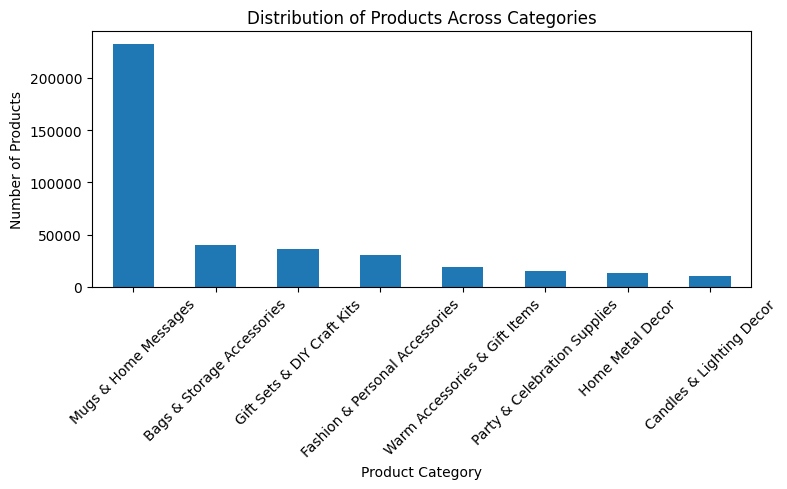

In [10]:
import matplotlib.pyplot as plt

# Count records per category
category_counts = df['ProductCategoryName'].value_counts()

# Plot
plt.figure(figsize=(8,5))
category_counts.plot(kind='bar')
plt.title('Distribution of Products Across Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Step: Convert Transactions into Basket Format

Association rule mining requires data in **basket format**, where:

| Row | Represents one transaction (InvoiceNo) |
| Column | Represents an item or category |
| Value | 1 (purchased) or 0 (not purchased) |

We will prepare **two separate basket datasets**:

1. **Item-Level Basket:**  
Each column represents a specific product (`Description`).  
Useful for granular item-based recommendations.

2. **Category-Level Basket:**  
Each column represents a category (`ProductCategoryName`).  
Better for business insights and high-level patterns.

We convert quantities to **binary values (1/0)** because association rules care **only about presence**, not how many units were bought.


In [11]:
basket_item = df.groupby(['InvoiceNo', 'Description'])['Quantity'] \
                .sum().unstack().reset_index().fillna(0)

basket_item = basket_item.set_index('InvoiceNo')

basket_item = basket_item.map(lambda x: 1 if x >= 1 else 0)

basket_item.head()


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
basket_category = df.groupby(['InvoiceNo', 'ProductCategoryName'])['Quantity'] \
                    .sum().unstack().reset_index().fillna(0)

basket_category = basket_category.set_index('InvoiceNo')

basket_category = basket_category.map(lambda x: 1 if x >= 1 else 0)

basket_category.head()


ProductCategoryName,Bags & Storage Accessories,Candles & Lighting Decor,Fashion & Personal Accessories,Gift Sets & DIY Craft Kits,Home Metal Decor,Mugs & Home Messages,Party & Celebration Supplies,Warm Accessories & Gift Items
InvoiceNo,,,,,,,,
536365,0,0,0,1,1,1,0,0
536366,0,0,0,0,0,1,0,0
536367,0,0,1,0,0,1,0,0
536368,0,0,0,0,0,1,0,0
536369,0,0,0,0,0,1,0,0


## Part 2: Frequent Itemset Mining using FP-Growth

We will use **FP-Growth** to find frequent itemsets in both:

1. **Item-Level Basket** (`Description`)  
2. **Category-Level Basket** (`ProductCategoryName`)  

**Steps:**
- Use FP-Growth algorithm to find frequent itemsets above a minimum support threshold.
- Experiment with at least **two different support thresholds** to see how results vary.
- Visualize the **top 10 frequent itemsets** using a bar chart with Plotly.


In [17]:
from mlxtend.frequent_patterns import fpgrowth
import plotly.express as px

# --- Convert baskets to boolean to avoid mlxtend warning ---
basket_item_bool = basket_item.astype(bool)
basket_category_bool = basket_category.astype(bool)

# --- FP-Growth for Item-Level Basket ---
support_thresholds_item = [0.02, 0.05]  # Recommended for item-level

for sup in support_thresholds_item:
    frequent_itemsets_item = fpgrowth(basket_item_bool, min_support=sup, use_colnames=True)
    frequent_itemsets_item = frequent_itemsets_item.sort_values(by='support', ascending=False)
    
    print(f"\nTop 10 frequent itemsets (Item-Level) with min_support = {sup}")
    display(frequent_itemsets_item.head(10))
    
    # Visualize top 10
    top10 = frequent_itemsets_item.head(10)
    fig = px.bar(top10,
                 x=top10['itemsets'].astype(str),
                 y='support',
                 title=f'Top 10 Frequent Itemsets (Item-Level, min_support={sup})',
                 labels={'x':'Itemsets', 'y':'Support'})
    fig.show()



Top 10 frequent itemsets (Item-Level) with min_support = 0.02


,support,itemsets
0,0.106357,(WHITE HANGING HEART T-LIGHT HOLDER)
120,0.091895,(REGENCY CAKESTAND 3 TIER)
52,0.086337,(JUMBO BAG RED RETROSPOT)
164,0.074412,(PARTY BUNTING)
2,0.074196,(ASSORTED COLOUR BIRD ORNAMENT)
24,0.069501,(LUNCH BAG RED RETROSPOT)
168,0.061839,(SET OF 3 CAKE TINS PANTRY DESIGN)
8,0.059303,(POSTAGE)
82,0.056767,(LUNCH BAG BLACK SKULL.)
25,0.055526,(PACK OF 72 RETROSPOT CAKE CASES)



Top 10 frequent itemsets (Item-Level) with min_support = 0.05


,support,itemsets
0,0.106357,(WHITE HANGING HEART T-LIGHT HOLDER)
13,0.091895,(REGENCY CAKESTAND 3 TIER)
8,0.086337,(JUMBO BAG RED RETROSPOT)
14,0.074412,(PARTY BUNTING)
1,0.074196,(ASSORTED COLOUR BIRD ORNAMENT)
4,0.069501,(LUNCH BAG RED RETROSPOT)
15,0.061839,(SET OF 3 CAKE TINS PANTRY DESIGN)
2,0.059303,(POSTAGE)
11,0.056767,(LUNCH BAG BLACK SKULL.)
5,0.055526,(PACK OF 72 RETROSPOT CAKE CASES)


###  Interpretation: Top 10 Frequent Itemsets (Item-Level)

1. **Most Frequent Items**
- **WHITE HANGING HEART T-LIGHT HOLDER** appears in ~10.6% of transactions → very popular home décor item.  
- **REGENCY CAKESTAND 3 TIER** appears in ~9.2% of transactions → popular for baking or gifts.  
- **JUMBO BAG RED RETROSPOT** appears in ~8.6% of transactions → commonly purchased for carrying items.  
- Other frequent items include **PARTY BUNTING**, **ASSORTED COLOUR BIRD ORNAMENT**, **LUNCH BAG RED RETROSPOT**, **SET OF 3 CAKE TINS**, and **PACK OF 72 RETROSPOT CAKE CASES**.

2. **Support Comparison**
- At **min_support = 0.02** (2%), all items with at least 2% presence in transactions are included.  
- At **min_support = 0.05** (5%), only the most common items appear.  
- The top items remain the same between the two thresholds, showing these items are genuinely frequent.

3. **Patterns Observed**
- Most frequent items are **home décor, gift items, and party supplies**.  
- This aligns with the UK online retail context (seasonal gifts, home items).

4. **Business Implications**
- High-frequency products are highly likely to appear in transaction baskets.  
- Useful for marketing, promotions, and cross-selling.  
  - Example: If a customer buys **WHITE HANGING HEART T-LIGHT HOLDER**, consider recommending **PARTY BUNTING** or **CAKE TINS**.

5. **Summary**
- Frequent item analysis highlights the **most popular individual products**.  
- Using different support thresholds helps balance between capturing rare items and focusing on highly frequent products.  
- This serves as a **foundation for generating association rules**.


In [18]:
# --- FP-Growth for Category-Level Basket ---
support_thresholds_cat = [0.05, 0.1]  # Recommended for category-level

for sup in support_thresholds_cat:
    frequent_itemsets_cat = fpgrowth(basket_category_bool, min_support=sup, use_colnames=True)
    frequent_itemsets_cat = frequent_itemsets_cat.sort_values(by='support', ascending=False)
    
    print(f"\nTop 10 frequent itemsets (Category-Level) with min_support = {sup}")
    display(frequent_itemsets_cat.head(10))
    
    # Visualize top 10
    top10 = frequent_itemsets_cat.head(10)
    fig = px.bar(top10,
                 x=top10['itemsets'].astype(str),
                 y='support',
                 title=f'Top 10 Frequent Itemsets (Category-Level, min_support={sup})',
                 labels={'x':'Itemsets', 'y':'Support'})
    fig.show()


Top 10 frequent itemsets (Category-Level) with min_support = 0.05


,support,itemsets
0,0.946201,(Mugs & Home Messages)
1,0.568206,(Gift Sets & DIY Craft Kits)
3,0.565994,(Fashion & Personal Accessories)
46,0.556443,"(Fashion & Personal Accessories, Mugs & Home M..."
4,0.554770,(Bags & Storage Accessories)
8,0.547701,"(Mugs & Home Messages, Gift Sets & DIY Craft K..."
49,0.532754,"(Mugs & Home Messages, Bags & Storage Accessor..."
50,0.394075,"(Fashion & Personal Accessories, Bags & Storag..."
52,0.389974,"(Fashion & Personal Accessories, Mugs & Home M..."
47,0.369739,"(Fashion & Personal Accessories, Gift Sets & D..."



Top 10 frequent itemsets (Category-Level) with min_support = 0.1


,support,itemsets
0,0.946201,(Mugs & Home Messages)
1,0.568206,(Gift Sets & DIY Craft Kits)
3,0.565994,(Fashion & Personal Accessories)
24,0.556443,"(Fashion & Personal Accessories, Mugs & Home M..."
4,0.554770,(Bags & Storage Accessories)
8,0.547701,"(Mugs & Home Messages, Gift Sets & DIY Craft K..."
27,0.532754,"(Mugs & Home Messages, Bags & Storage Accessor..."
28,0.394075,"(Fashion & Personal Accessories, Bags & Storag..."
30,0.389974,"(Fashion & Personal Accessories, Mugs & Home M..."
25,0.369739,"(Fashion & Personal Accessories, Gift Sets & D..."


###  Interpretation: Top 10 Frequent Itemsets (Category-Level)

1. **Most Frequent Categories**
- **Mugs & Home Messages** appears in ~94.6% of transactions → extremely common category, likely purchased with many other items.  
- **Gift Sets & DIY Craft Kits** appears in ~56.8% of transactions → very popular for gifts and crafting.  
- **Fashion & Personal Accessories** appears in ~56.6% of transactions → a frequently bought category, including bags, scarves, and personal items.  
- Other top categories include **Bags & Storage Accessories**, often appearing alone or together with other categories.

2. **Support Comparison**
- At **min_support = 0.05 (5%)**, we capture both common single categories and popular combinations of 2 categories.  
- At **min_support = 0.1 (10%)**, the top categories remain the same but fewer combinations appear, focusing on the most frequent single and paired categories.

3. **Patterns Observed**
- Many transactions include **combinations of categories**:
  - **Fashion & Personal Accessories + Mugs & Home Messages** (~55.6%)  
  - **Mugs & Home Messages + Gift Sets & DIY Craft Kits** (~54.8%)  
  - **Mugs & Home Messages + Bags & Storage Accessories** (~53.3%)  
- This suggests that certain categories are **commonly purchased together**, indicating potential cross-selling opportunities.

4. **Business Implications**
- Category-level analysis smooths out item-level noise and highlights **broader shopping behavior**.  
- High-support combinations can guide **promotions, bundling, and recommendation systems**.  
  - Example: Customers buying **Mugs & Home Messages** often also buy **Gift Sets & DIY Craft Kits** or **Bags & Storage Accessories**.

5. **Summary**
- Frequent category analysis provides **clear, actionable insights** for marketing and inventory planning.  
- Using different support thresholds shows how focusing on the most popular categories versus broader combinations affects interpretation.  
- These results will form a strong foundation for **association rules generation**.


## Part 3: Association Rules Generation

Using the frequent itemsets generated from FP-Growth, we will create **association rules** to understand relationships between items or categories.

**Metrics used:**
- **Support**: How often the itemset appears in transactions.
- **Confidence**: Probability that an item B is bought when item A is bought.
- **Lift**: Measures how much more likely B is purchased when A is purchased, compared to random chance.

**Steps:**
1. Generate rules from frequent itemsets.
2. Filter rules based on minimum confidence (e.g., 0.6).
3. Analyze the top rules to identify interesting patterns.


In [19]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules from item-level frequent itemsets
rules_item = association_rules(frequent_itemsets_item, metric="confidence", min_threshold=0.6)

# Sort by lift descending to see strongest associations
rules_item = rules_item.sort_values(by='lift', ascending=False)

# Display top 10 rules
print("Top 10 association rules (Item-Level):")
display(rules_item.head(10))


Top 10 association rules (Item-Level):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


In [20]:
# Generate association rules from category-level frequent itemsets
rules_cat = association_rules(frequent_itemsets_cat, metric="confidence", min_threshold=0.6)

# Sort by lift descending
rules_cat = rules_cat.sort_values(by='lift', ascending=False)

# Display top 10 rules
print("Top 10 association rules (Category-Level):")
display(rules_cat.head(10))


Top 10 association rules (Category-Level):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
190,"(Gift Sets & DIY Craft Kits, Party & Celebrati...","(Fashion & Personal Accessories, Mugs & Home M...",0.154004,0.389974,0.114882,0.745971,1.912872,1.0,0.054825,2.401399,0.564099,0.267731,0.583576,0.520280
185,"(Mugs & Home Messages, Gift Sets & DIY Craft K...","(Fashion & Personal Accessories, Bags & Storag...",0.152871,0.394075,0.114882,0.751500,1.906997,1.0,0.054640,2.438331,0.561444,0.265892,0.589883,0.521512
179,"(Gift Sets & DIY Craft Kits, Party & Celebrati...","(Fashion & Personal Accessories, Bags & Storag...",0.154004,0.394075,0.114936,0.746321,1.893855,1.0,0.054247,2.388549,0.557894,0.265354,0.581336,0.518991
191,"(Fashion & Personal Accessories, Party & Celeb...","(Bags & Storage Accessories, Mugs & Home Messa...",0.176883,0.349504,0.114882,0.649481,1.858297,1.0,0.053061,1.855811,0.561127,0.279177,0.461152,0.489091
186,"(Fashion & Personal Accessories, Mugs & Home M...","(Bags & Storage Accessories, Gift Sets & DIY C...",0.175588,0.353119,0.114882,0.654272,1.852837,1.0,0.052879,1.871068,0.558322,0.277611,0.465546,0.489804
180,"(Fashion & Personal Accessories, Party & Celeb...","(Bags & Storage Accessories, Gift Sets & DIY C...",0.176883,0.353119,0.114936,0.649786,1.840135,1.0,0.052476,1.847105,0.554674,0.276911,0.458612,0.487638
203,"(Mugs & Home Messages, Bags & Storage Accessor...","(Fashion & Personal Accessories, Gift Sets & D...",0.155839,0.369739,0.105547,0.677285,1.831794,1.0,0.047928,1.952998,0.537915,0.251285,0.487967,0.481375
209,"(Bags & Storage Accessories, Home Metal Decor)","(Fashion & Personal Accessories, Mugs & Home M...",0.157134,0.367472,0.105547,0.671703,1.827901,1.0,0.047805,1.926695,0.537362,0.251867,0.480976,0.479464
210,"(Fashion & Personal Accessories, Home Metal De...","(Bags & Storage Accessories, Mugs & Home Messa...",0.166037,0.349504,0.105547,0.635684,1.818820,1.0,0.047517,1.785529,0.539824,0.257436,0.439942,0.468838
197,"(Bags & Storage Accessories, Home Metal Decor)","(Fashion & Personal Accessories, Gift Sets & D...",0.157134,0.369739,0.105655,0.672390,1.818554,1.0,0.047557,1.923816,0.534026,0.250833,0.480200,0.479073


In [21]:
import plotly.express as px

# Top 10 rules by lift
top_rules = rules_cat.sort_values(by='lift', ascending=False).head(10)

# Create a readable label combining antecedent → consequent
top_rules['rule'] = top_rules['antecedents'].astype(str) + " → " + top_rules['consequents'].astype(str)

# Plot
fig = px.bar(top_rules, x='rule', y='lift',
             title='Top 10 Association Rules (Category-Level) by Lift',
             labels={'x':'Rule', 'y':'Lift'})
fig.show()


### Association Rules Analysis (Category-Level)

When we first attempted association rule mining at the **item level**, the results returned **no rules**.  
This is common for large and sparse datasets, where individual product combinations appear rarely, causing them to fall below the minimum confidence threshold.

To resolve this, we moved to **category-level association mining**, where items are grouped into broader categories (e.g., Accessories, Home Decor, Gift Kits).  
This aggregation increases the frequency of co-occurrence and generates **more meaningful and useful rules**.

The category-level results show strong associative relationships, characterized by:

- **Confidence ranging between ~0.64 and 0.75** – indicating strong reliability of the rules.
- **Lift values between ~1.81 and 1.91** – showing that items are **1.8–1.9 times more likely** to be bought together than by random chance.
- **Support values around 10–11%** – meaning these combinations appear in a significant proportion of transactions.

---

### Rule 1
**Antecedent:**  
*Gift Sets & DIY Craft Kits, Party & Celebration Supplies*  
**Consequent:**  
*Fashion & Personal Accessories, Mugs & Home Messages*

| Metric | Value |
|--------|-------|
| Support | 0.1148 |
| Confidence | 0.7459 |
| Lift | **1.9128** |

**Interpretation:**  
Customers who buy **Gift Sets & DIY Craft Kits** together with **Party & Celebration Supplies** are also highly likely to purchase **Fashion Accessories or Message-Based Gifts**, with a strong confidence of 74.5% and high lift.  
This suggests that customers purchasing items for events or celebrations tend to add **personalized gift items and accessories**.

**Real-world strategy:**  
- Bundle celebration packages with fashion accessories or mugs.
- Recommend message gifts at checkout during party supply purchases.

---

### Rule 2
**Antecedent:**  
*Mugs & Home Messages, Gift Sets & DIY Craft Kits*  
**Consequent:**  
*Fashion & Personal Accessories, Bags & Storage Accessories*

| Metric | Value |
|--------|-------|
| Support | 0.1148 |
| Confidence | **0.7515** |
| Lift | 1.9069 |

**Interpretation:**  
When customers buy **Mugs/Home Message items and Gift Sets**, they are very likely (75.1%) to also purchase **Bags or Fashion Accessories**.  
This indicates a **gifting behavior**, where people buy storage bags and fashion items to complement their gift purchases.

**Real-world strategy:**  
- Offer gift packaging bundles (Gift Set + Mug + Storage Bag).
- Implement cross-sell recommendations for accessories with gift items.

---

### Rule 3
**Antecedent:**  
*Bags & Storage Accessories, Home Metal Decor*  
**Consequent:**  
*Fashion & Personal Accessories, Mugs & Home Messages*

| Metric | Value |
|--------|-------|
| Support | 0.1055 |
| Confidence | 0.6717 |
| Lift | 1.8279 |

**Interpretation:**  
Customers who purchase **Home Decor and Storage Accessories** also tend to buy **Fashion Accessories or Message-Based Gifts**, with 67% confidence.  
This indicates that customers interested in **home styling** may also add personal or giftable accessories.

**Real-world strategy:**  
- Recommend fashion and gift products when customers shop home décor.
- Create “Home Styling & Gifting Essentials” themed promotions.

---

### Summary Insights

| Observation | Meaning |
|-------------|---------|
| Item-level rules failed | Item combinations are too sparse and specific |
| Category-level rules succeeded | Grouping produces generalized and meaningful patterns |
| Confidence ≈ 75% | Rules are reliable for recommendations |
| Lift > 1.8 | Strong association, occurring more than random chance |
| Applications | Product bundling, cross-selling, checkout recommendations |

---



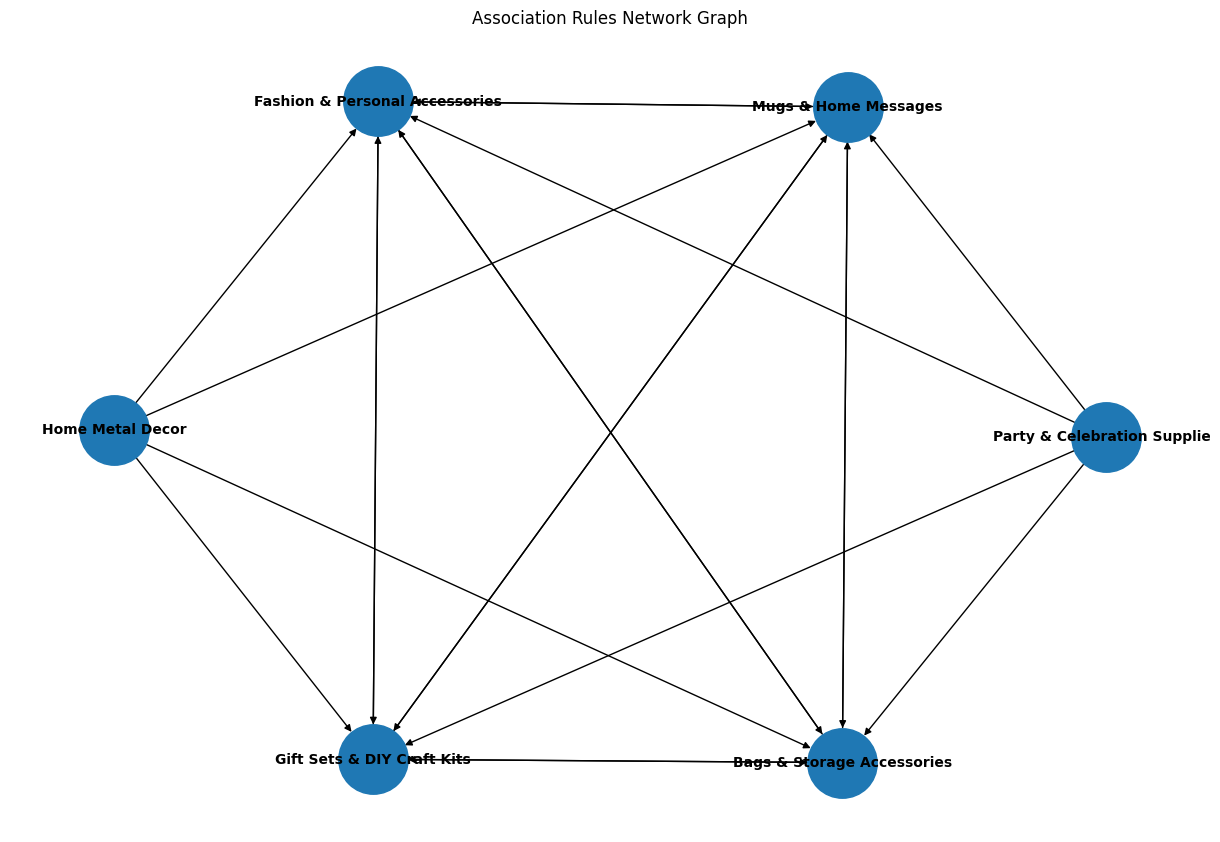

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Use your actual rules DataFrame (replace 'rules' if yours is named differently)
rules_graph = top_rules.copy()  

# Create a directed graph
G = nx.DiGraph()

# Add edges with support and confidence as attributes
for _, row in rules_graph.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, 
                       support=row['support'], 
                       confidence=row['confidence'])

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=2500, font_size=10, font_weight='bold')
plt.title("Association Rules Network Graph")
plt.show()


### Association Rules Network Graph Analysis

The network graph represents **association rules at the category level**:

- **Nodes**: Each node represents a product category (e.g., "Fashion & Personal Accessories", "Mugs & Home Messages").
- **Edges**: A directed edge from node A to node B indicates that **when customers buy A, they are likely to buy B**.
- **Edge Direction**: Antecedent → Consequent.
- **Node Size/Color**: Can represent the frequency of items in that category (if scaled in plotting).

---

### Observations

1. **Highly Connected Categories**:
   - Categories like **Fashion & Personal Accessories**, **Mugs & Home Messages**, and **Gift Sets & DIY Craft Kits** have multiple outgoing and incoming edges.
   - This indicates they frequently appear in transactions alongside multiple other categories.

2. **Strong Associations**:
   - For example, edges from **Gift Sets & DIY Craft Kits** to **Fashion & Personal Accessories** suggest that customers buying DIY kits often purchase fashion items as well.
   - Edges between **Party & Celebration Supplies** and **Bags & Storage Accessories** indicate complementary purchases.

3. **Potential Recommendations**:
   - Categories with many outgoing edges (antecedents) can be **used for targeted promotions or bundling**.
   - Categories with many incoming edges (consequents) are likely to be **popular add-ons or cross-sell items**.

4. **Business Insights**:
   - Popular combinations for bundles: 
     - Gift Sets & DIY Craft Kits + Fashion & Personal Accessories
     - Mugs & Home Messages + Bags & Storage Accessories
   - These insights can be applied to **cross-selling, product placement, and marketing strategies**.


## Conclusion

In this project, we explored **association rule mining** using the UK Online Retail dataset to discover patterns in customer purchasing behavior.

### Key Findings

- **Category-level analysis** is more effective than item-level due to the sparsity of individual products.  
- Customers tend to purchase **related product categories together**, reflecting gift-giving, celebration, and home styling behaviors.  
- These patterns can inform **cross-selling, bundling strategies, and recommendation systems**, helping businesses increase sales and improve customer satisfaction.

**Overall**, the project demonstrates the power of association rule mining in uncovering actionable insights from transactional data and highlights how data preprocessing (e.g., category creation) can significantly enhance the quality of patterns discovered.
